In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Импорт "сырых" данных

In [11]:
raw_xls = pd.read_csv('https://raw.githubusercontent.com/RusinDima12/BSR/main/data/raw_from_xls.csv')
raw_xls.head(3)

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,49.0,0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0,0,0,0,0,1,NaN,0,0.0,0.0
1,65.0,0,0.0,1.0,2.0,1.0,NaN,2.0,0.0,NaN,...,0,0,0,1,0,0,0.0,0,0.0,0.0
2,58.0,1,0.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0.0,0,0.0,0.0


# Анализ качества данных (пропуски, выбросы)

In [14]:
print('Число записей БД:', raw_xls.shape[0])
print('Число полей БД:', raw_xls.shape[1])

Число записей БД: 1700
Число полей БД: 123


In [15]:
target_columns = ['LET_IS']
target_columns_new = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 
                 'A_V_BLOK', 'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN'
                 , 'REC_IM', 'P_IM_STEN']
inputs_columns = raw_xls.drop(columns=['LET_IS']).columns.values

In [16]:
death_dict = {1: 'Кардиогенный шок',
2: 'Отек легких',
3: 'Разрыв сердца',
4: 'Прогрессирование застойной сердечн. недостаточности',
5: 'Тромбоэмболия',
6: 'Асистолия',
7: 'фибрилляция желудочков'}

In [17]:
raw_xls['LET_IS'].unique()

array([ 0.,  3.,  7.,  5.,  2.,  4.,  1., nan,  6.])

In [18]:
raw_xls['DEATH'] = raw_xls['LET_IS'].apply(lambda x: 1 if x > 0 else 0)

## Пропуски

Поля без пропусков

In [19]:
raw_xls.isnull().sum()[raw_xls.isnull().sum()==0]

SEX           0
PREDS_TAH     0
JELUD_TAH     0
FIBR_JELUD    0
A_V_BLOK      0
OTEK_LANC     0
RAZRIV        0
DRESSLER      0
REC_IM        0
DEATH         0
dtype: int64

Количество пропусков по всем переменным

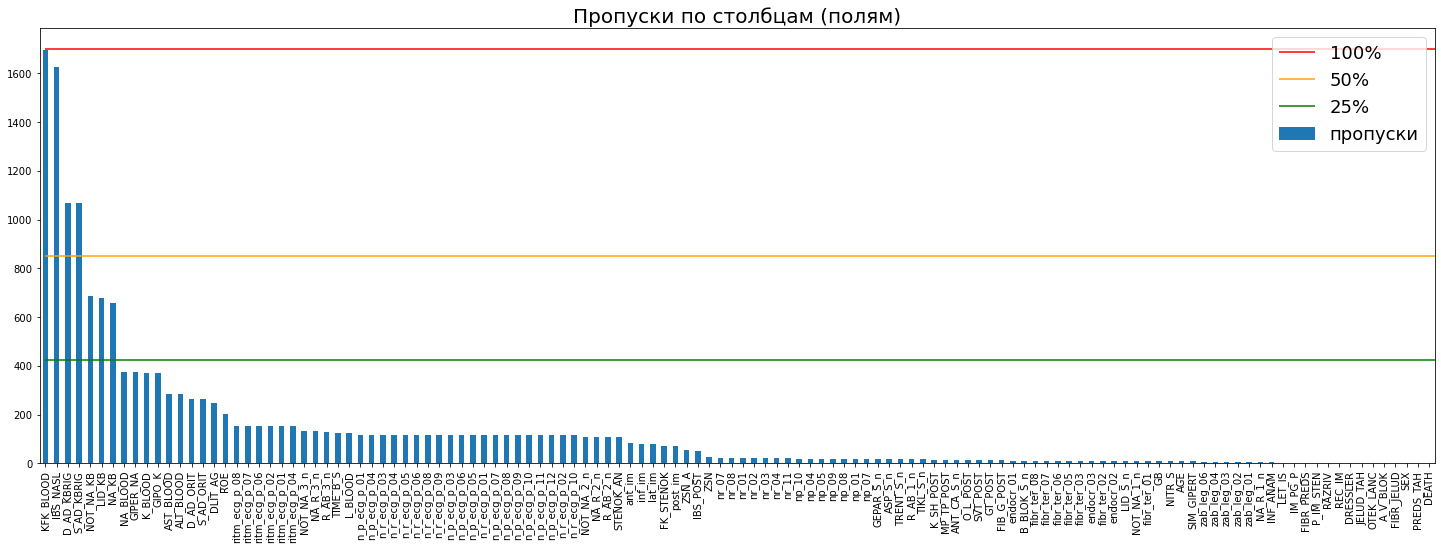

In [20]:
fig, ax = plt.subplots(figsize=(25,8))
raw_xls.isnull().sum().sort_values(ascending=False).plot(kind='bar',  ax=ax, label='пропуски')
ax.hlines(raw_xls.shape[0], 0, raw_xls.shape[1], color='red', label='100%')
ax.hlines(int(raw_xls.shape[0]/2), 0, raw_xls.shape[1], color='orange', label='50%')
ax.hlines(int(raw_xls.shape[0]/4), 0, raw_xls.shape[1], color='green', label='25%')
ax.legend(fontsize=18)
ax.set_title('Пропуски по столбцам (полям)', fontsize=20)
plt.show()

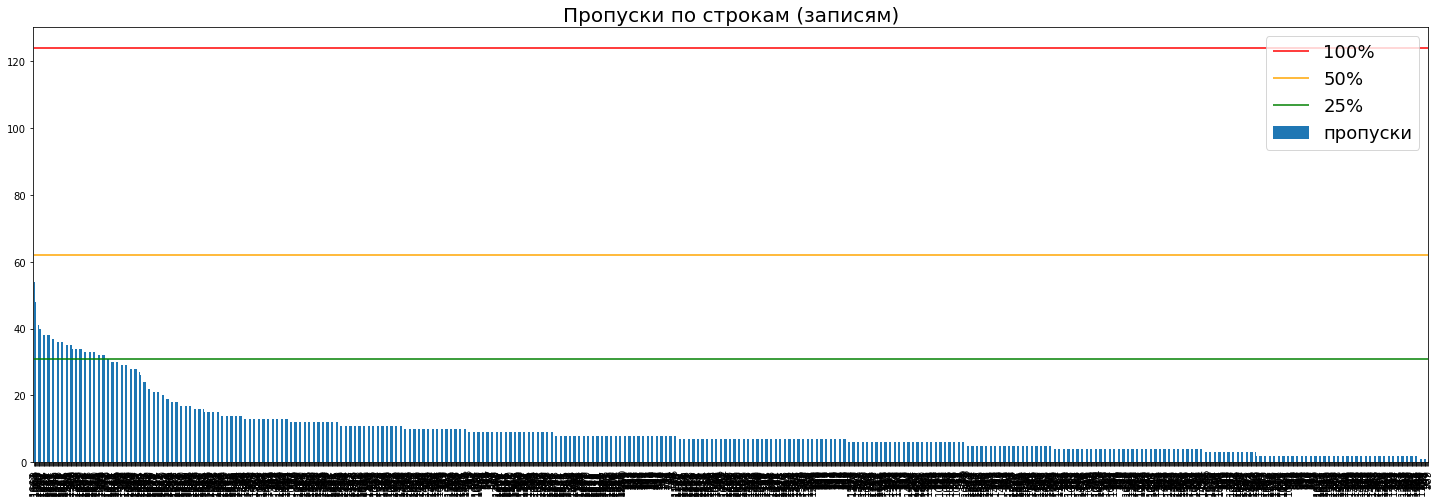

In [21]:
fig, ax = plt.subplots(figsize=(25,8))
raw_xls.isnull().sum(axis=1).sort_values(ascending=False).plot(kind='bar',  ax=ax, label='пропуски')
ax.hlines(raw_xls.shape[1], 0, raw_xls.shape[0], color='red', label='100%')
ax.hlines(int(raw_xls.shape[1]/2), 0, raw_xls.shape[0], color='orange', label='50%')
ax.hlines(int(raw_xls.shape[1]/4), 0, raw_xls.shape[0], color='green', label='25%')
ax.legend(fontsize=18)
ax.set_title('Пропуски по строкам (записям)', fontsize=20)
plt.show()

<AxesSubplot:>

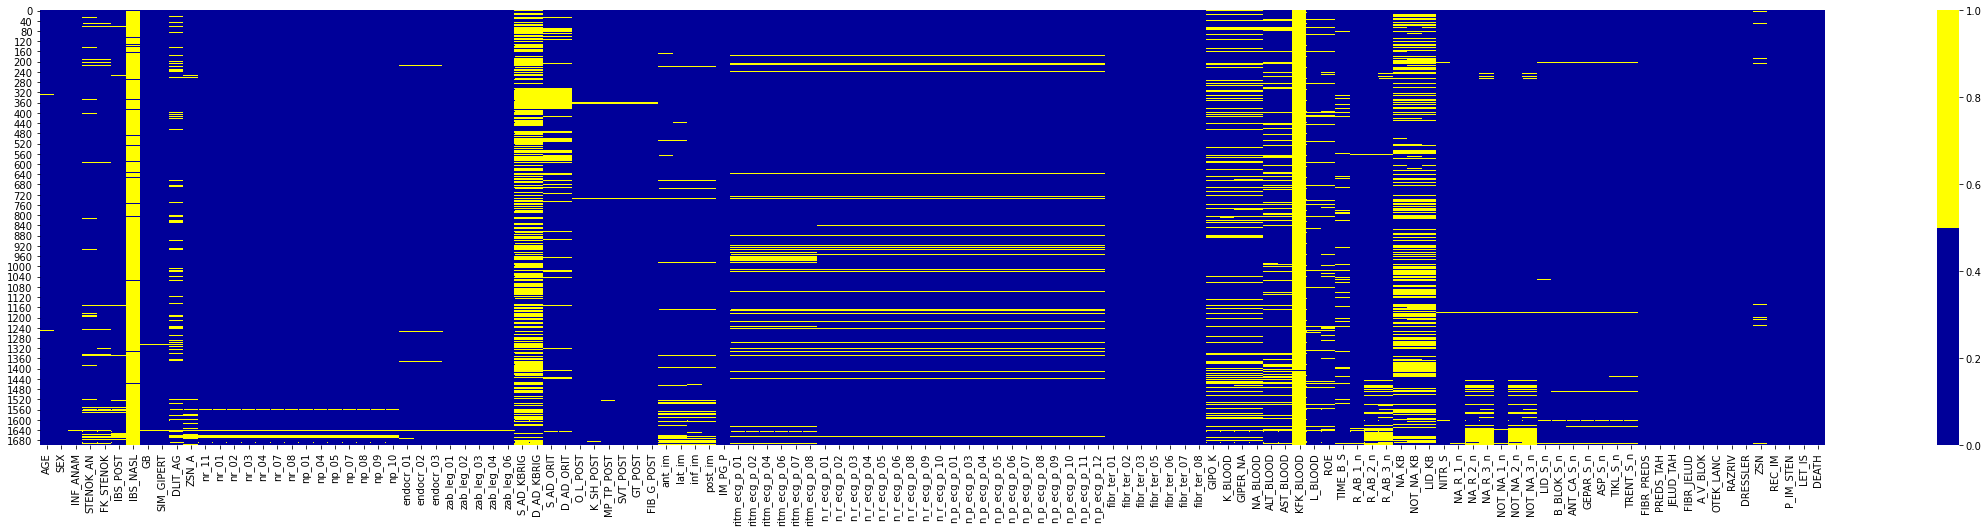

In [22]:
cols = raw_xls.columns 
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
plt.figure(figsize=(40, 8))
sns.heatmap(raw_xls[cols].isnull(), cmap=sns.color_palette(colours))

TODO: попробовать разные методы:

* БД без столбцов/строк где много пропусков
* заполнить средним/модой
* kNN

Удаление строк где пропусков > 25%

Удаление столбцов где пропусков > 50%

In [23]:
raw_xls = raw_xls.drop(raw_xls.loc[raw_xls.isnull().sum(axis=1).sort_values(ascending=False)>raw_xls.shape[1]/4].index)
for column in raw_xls.columns:
    if raw_xls[column].isnull().sum()>raw_xls.shape[0]/2:
        del raw_xls[column]
raw_xls

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DEATH
0,49.0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,NaN,0,0.0,0.0,0
1,65.0,0,0.0,1.0,2.0,1.0,2.0,0.0,NaN,0.0,...,0,0,1,0,0,0.0,0,0.0,0.0,0
2,58.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
3,43.0,1,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
4,49.0,1,0.0,4.0,2.0,1.0,2.0,0.0,3.0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,1,0,0.0,0,0.0,3.0,1
1696,70.0,0,0.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0,0,0,1,0,0.0,0,0.0,3.0,1
1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,...,0,0,0,0,0,0.0,0,0.0,1.0,1
1698,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,NaN,...,0,0,1,0,0,0.0,0,0.0,1.0,1


## Категориальные/числовые данные

In [24]:
numeric_features = ['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD'
                    ,'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE']#'KFK_BLOOD'
categorical_features = ['SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK'
                        , 'IBS_POST', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A'
                        ,'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07'
                        , 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
                        , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02'
                        , 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
                        , 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST'
                        , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST'
                        , 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P'
                        , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04'
                        , 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
                        , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03'
                        , 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06'
                        , 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10'
                        , 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04'
                        , 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07'
                        , 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10'
                        , 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
                        , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05'
                        , 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08'
                        ,'GIPO_K', 'GIPER_NA', 'TIME_B_S', 'R_AB_1_n'
                        , 'R_AB_2_n', 'R_AB_3_n', 'NA_KB', 'NOT_NA_KB'
                        , 'LID_KB', 'NITR_S', 'NA_R_1_n', 'NA_R_2_n'
                        , 'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n'
                        , 'NOT_NA_3_n', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n'
                        , 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']
numeric_features_int = ['AGE', 'S_AD_ORIT','D_AD_ORIT','NA_BLOOD','ROE']
binary_features = ['SEX', 'IBS_NASL', 'SIM_GIPERT','nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04'
                   , 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07'
                   , 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02'
                   , 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03'
                   , 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST'
                   , 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST','IM_PG_P'
                   , 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04'
                   , 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08'
                   , 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03'
                   , 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06'
                   , 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10'
                   , 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04'
                   , 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07'
                   , 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10'
                   , 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01'
                   , 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05'
                   , 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08'
                   ,'GIPO_K', 'GIPER_NA', 'NA_KB', 'NOT_NA_KB', 'LID_KB'
                   , 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n'
                   , 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']

In [25]:
set_difference = set(categorical_features).symmetric_difference(set(binary_features))
list_difference = list(set_difference)

In [26]:
list_difference

['TIME_B_S',
 'ZSN_A',
 'NA_R_3_n',
 'NOT_NA_2_n',
 'post_im',
 'GB',
 'STENOK_AN',
 'lat_im',
 'IBS_POST',
 'NOT_NA_3_n',
 'R_AB_3_n',
 'INF_ANAM',
 'NOT_NA_1_n',
 'ant_im',
 'DLIT_AG',
 'FK_STENOK',
 'IBS_NASL',
 'inf_im',
 'NA_R_2_n',
 'NA_R_1_n',
 'R_AB_2_n',
 'R_AB_1_n']

In [27]:
raw_xls[numeric_features].head()

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE
0,49.0,120.0,70.0,3.9,130.0,0.23,0.26,5.7,7.0
1,65.0,140.0,80.0,3.9,140.0,NaN,NaN,9.1,5.0
2,58.0,140.0,80.0,NaN,NaN,0.38,0.15,9.0,5.0
3,43.0,120.0,80.0,4.3,136.0,0.75,0.48,9.9,3.0
4,49.0,130.0,90.0,3.6,136.0,0.52,0.30,8.1,2.0


Заполнение средним числовые данные

In [45]:
avg_data = raw_xls.copy()
for i in numeric_features:
    if i in numeric_features_int:
        avg_data[i]=avg_data[i].fillna(int(avg_data[i].mean()))
    else:
        avg_data[i]=avg_data[i].fillna(avg_data[i].mean())

for i in categorical_features:
    avg_data[i]=avg_data[i].fillna(int(avg_data[i].mean()))


In [29]:
avg_data.describe()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DEATH
count,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,...,1611.00000,1611.000000,1611.000000,1611.000000,1611.000000,1587.000000,1611.000000,1610.000000,1609.000000,1611.000000
mean,61.728119,0.626940,0.554935,2.270639,1.189323,1.152079,1.387958,0.032899,3.281192,0.187461,...,0.04221,0.032899,0.092489,0.033520,0.045934,0.236295,0.089385,0.081366,0.479180,0.158908
std,11.329424,0.483768,0.894388,2.367482,1.036375,0.793506,1.088770,0.178427,2.876508,0.648642,...,0.20113,0.178427,0.289805,0.180045,0.209407,0.424939,0.285388,0.273482,1.382988,0.365703
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,1.000000,0.000000,2.000000,2.000000,1.000000,2.000000,0.000000,3.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,1.000000,1.000000,5.000000,2.000000,2.000000,2.000000,0.000000,7.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,92.000000,1.000000,6.000000,6.000000,8.000000,2.000000,3.000000,1.000000,10.000000,4.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000


Заполнение модой

In [46]:
moda_data = raw_xls.copy()
for i in numeric_features:
    moda_data[i]=moda_data[i].fillna(moda_data[i].mode().values[0])
for i in categorical_features:
    moda_data[i]=moda_data[i].fillna(moda_data[i].mode().values[0])

In [31]:
moda_data.describe()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DEATH
count,1611.000000,1611.000000,1611.000000,1611.00000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,1611.000000,...,1611.00000,1611.000000,1611.000000,1611.000000,1611.000000,1587.000000,1611.000000,1610.000000,1609.000000,1611.000000
mean,61.736809,0.626940,0.554935,2.16139,1.225947,1.176909,1.390441,0.032899,2.862197,0.187461,...,0.04221,0.032899,0.092489,0.033520,0.045934,0.236295,0.089385,0.081366,0.479180,0.158908
std,11.329629,0.483768,0.894388,2.42298,1.046661,0.803943,1.089023,0.178427,3.097124,0.648642,...,0.20113,0.178427,0.289805,0.180045,0.209407,0.424939,0.285388,0.273482,1.382988,0.365703
min,26.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,0.000000,0.000000,0.00000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.000000,1.000000,0.000000,1.00000,2.000000,1.000000,2.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,1.000000,1.000000,5.00000,2.000000,2.000000,2.000000,0.000000,7.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,92.000000,1.000000,6.000000,6.00000,8.000000,2.000000,3.000000,1.000000,10.000000,4.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000


Заполнение методом KNN

In [47]:
imputer = KNNImputer(n_neighbors=5)
knn_data = pd.DataFrame(imputer.fit_transform(raw_xls),columns = raw_xls.columns)

In [33]:
knn_data.isna().any()

AGE          False
SEX          False
INF_ANAM     False
STENOK_AN    False
FK_STENOK    False
             ...  
ZSN          False
REC_IM       False
P_IM_STEN    False
LET_IS       False
DEATH        False
Length: 120, dtype: bool

AGE             AxesSubplot(0.125,0.125;0.0731132x0.755)
S_AD_ORIT    AxesSubplot(0.212736,0.125;0.0731132x0.755)
D_AD_ORIT    AxesSubplot(0.300472,0.125;0.0731132x0.755)
K_BLOOD      AxesSubplot(0.388208,0.125;0.0731132x0.755)
NA_BLOOD     AxesSubplot(0.475943,0.125;0.0731132x0.755)
ALT_BLOOD    AxesSubplot(0.563679,0.125;0.0731132x0.755)
AST_BLOOD    AxesSubplot(0.651415,0.125;0.0731132x0.755)
L_BLOOD      AxesSubplot(0.739151,0.125;0.0731132x0.755)
ROE          AxesSubplot(0.826887,0.125;0.0731132x0.755)
dtype: object

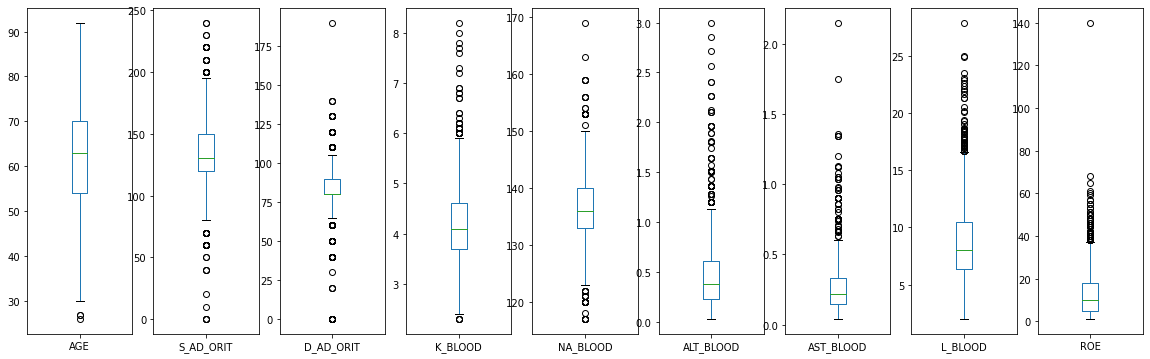

In [34]:
raw_xls[numeric_features].plot(kind='box', subplots=True, figsize=(20,6))

AGE             AxesSubplot(0.125,0.125;0.0731132x0.755)
S_AD_ORIT    AxesSubplot(0.212736,0.125;0.0731132x0.755)
D_AD_ORIT    AxesSubplot(0.300472,0.125;0.0731132x0.755)
K_BLOOD      AxesSubplot(0.388208,0.125;0.0731132x0.755)
NA_BLOOD     AxesSubplot(0.475943,0.125;0.0731132x0.755)
ALT_BLOOD    AxesSubplot(0.563679,0.125;0.0731132x0.755)
AST_BLOOD    AxesSubplot(0.651415,0.125;0.0731132x0.755)
L_BLOOD      AxesSubplot(0.739151,0.125;0.0731132x0.755)
ROE          AxesSubplot(0.826887,0.125;0.0731132x0.755)
dtype: object

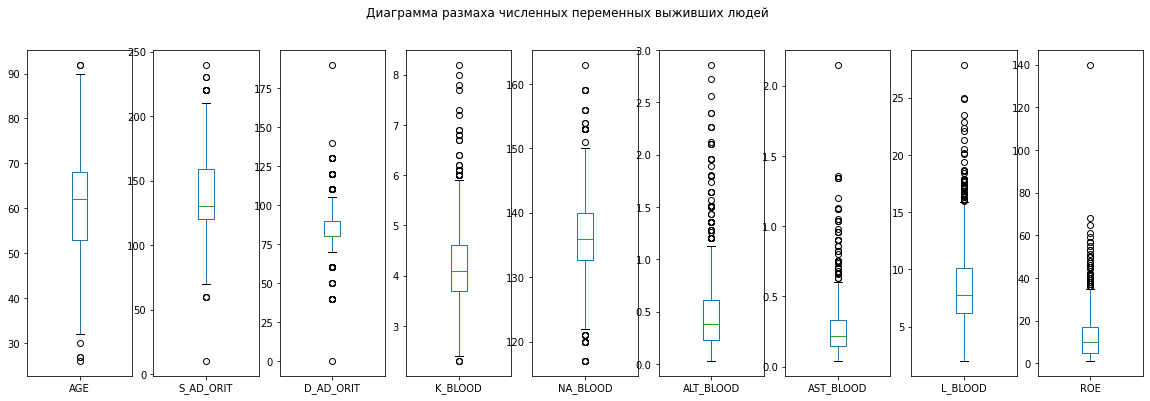

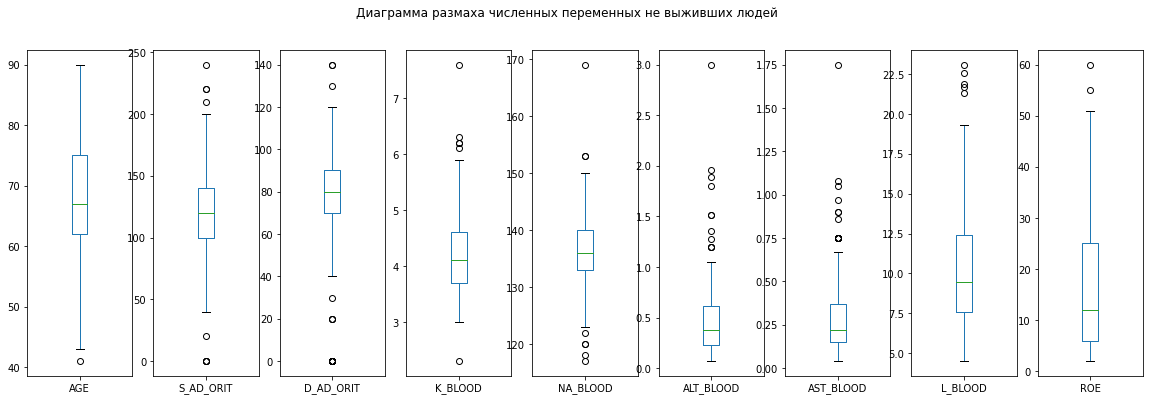

In [35]:
raw_xls[numeric_features].loc[raw_xls['LET_IS'] == 0].plot(kind='box',title = 'Диаграмма размаха численных переменных выживших людей', subplots=True, figsize=(20,6))
raw_xls[numeric_features].loc[raw_xls['LET_IS'] > 0].plot(kind='box', title = 'Диаграмма размаха численных переменных не выживших людей', subplots=True, figsize=(20,6))

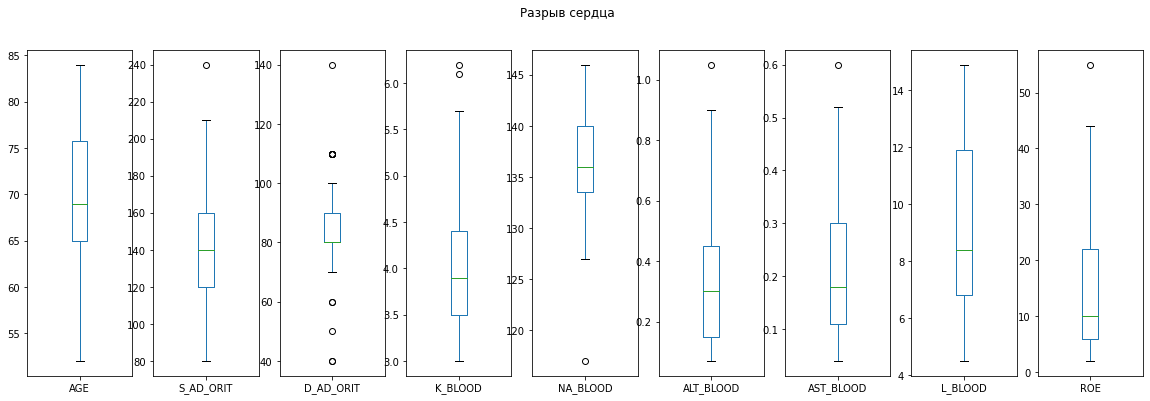

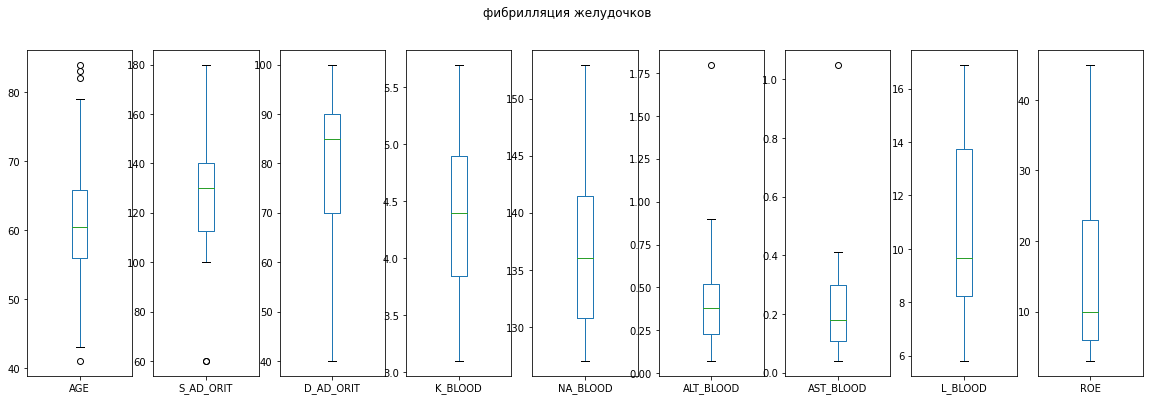

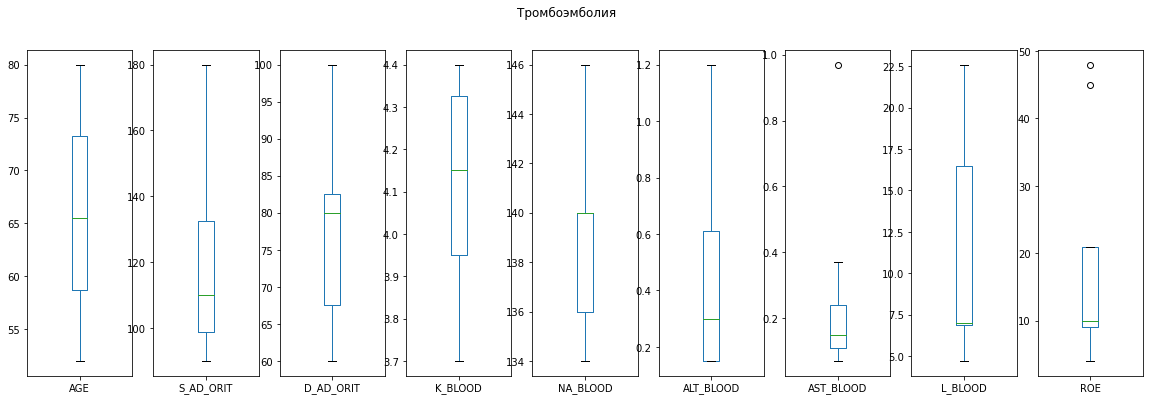

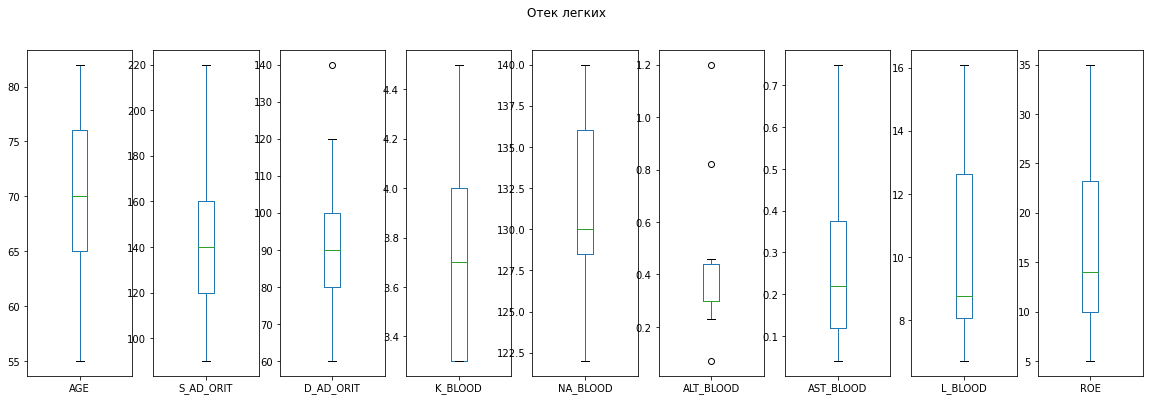

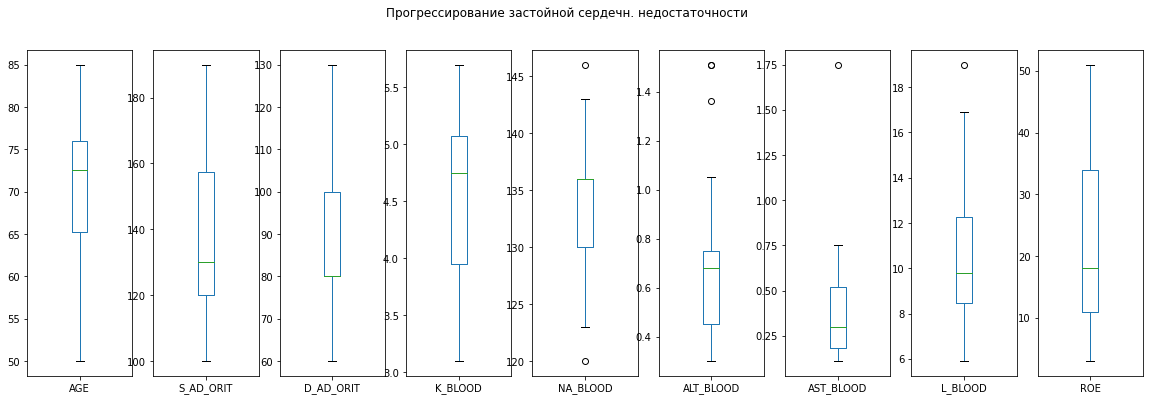

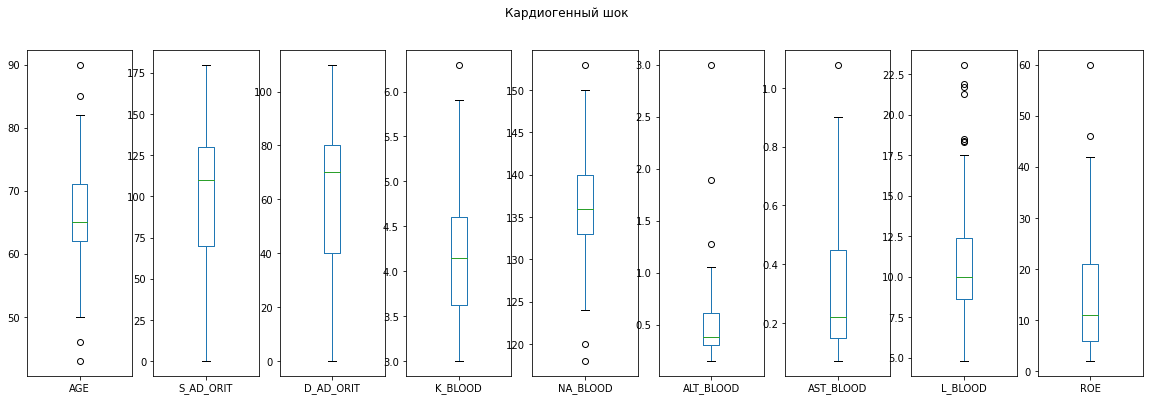

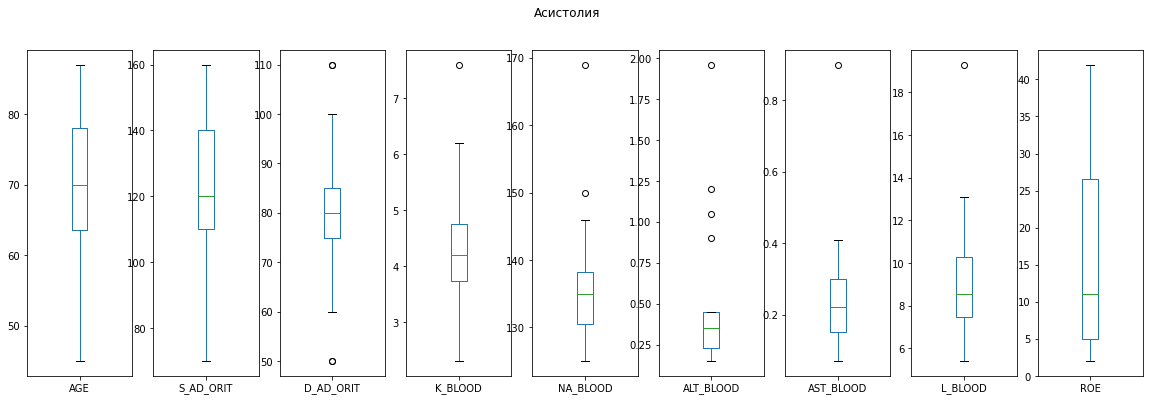

In [19]:
for i in raw_xls['LET_IS'].unique():
    if i > 0:
        raw_xls[numeric_features].loc[raw_xls['LET_IS'] == i].plot(kind='box', title = death_dict[i], subplots=True, figsize=(20,6))  

<AxesSubplot:ylabel='Frequency'>

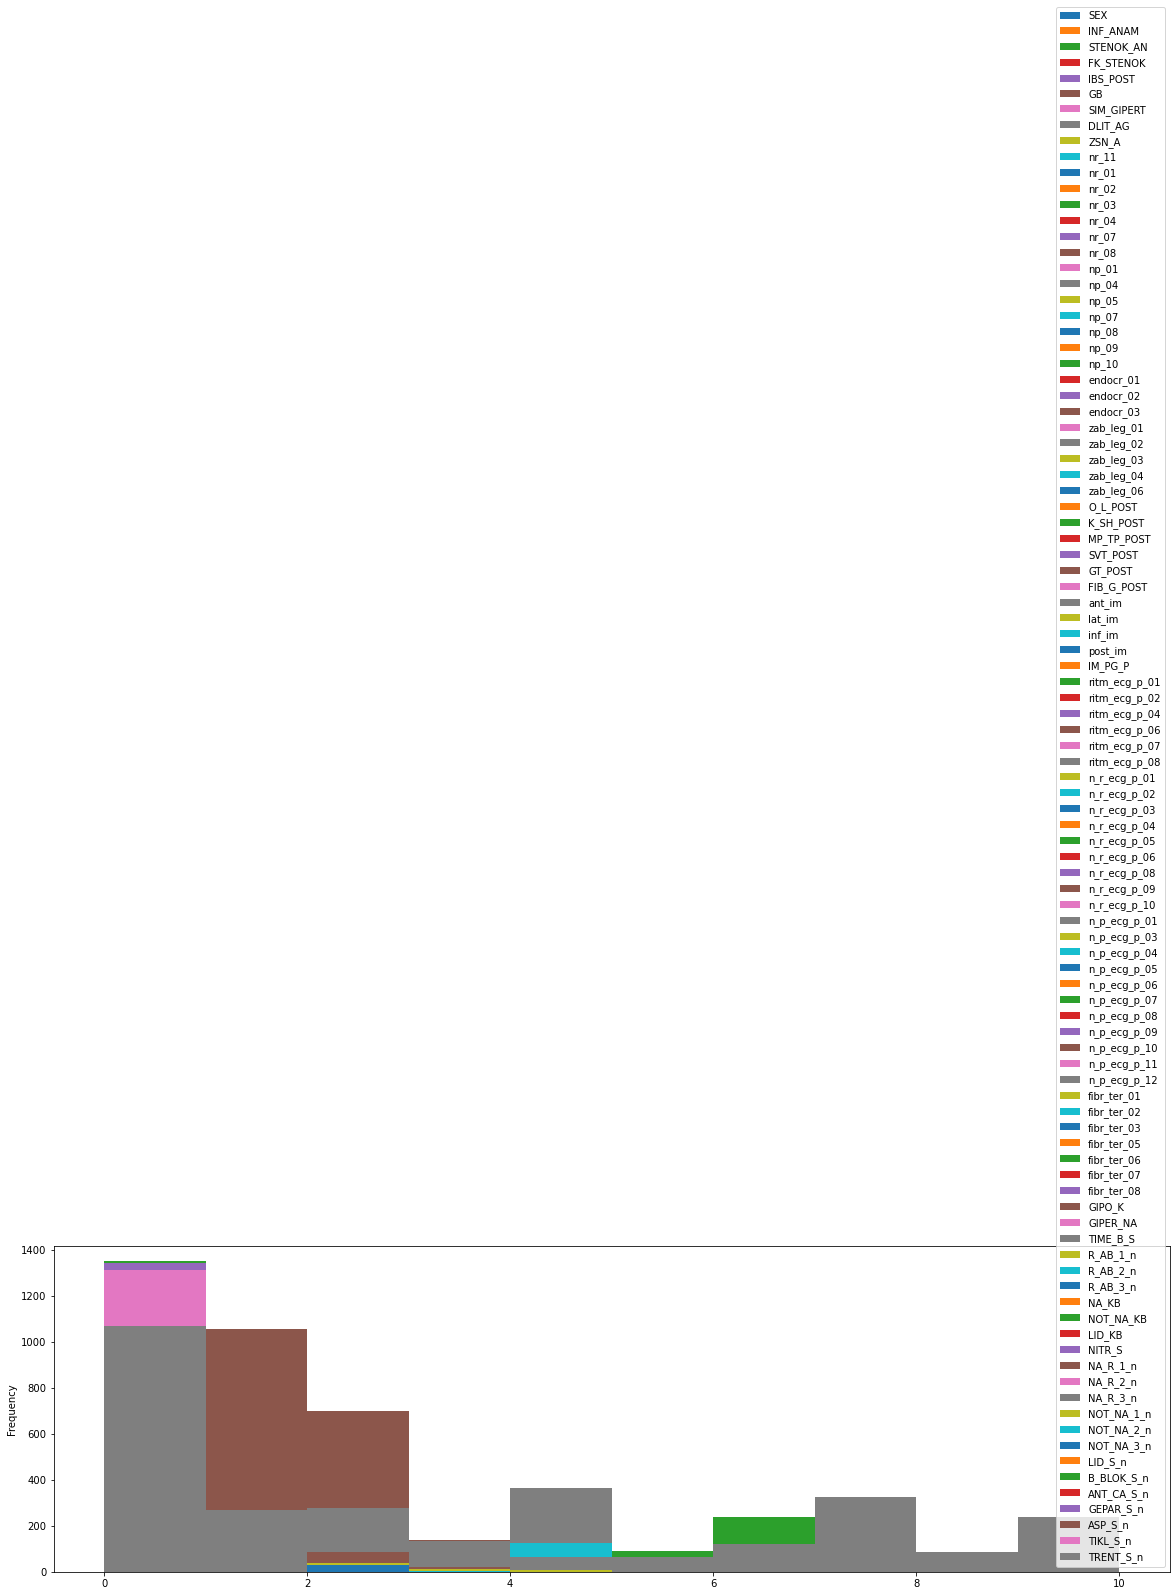

In [205]:
raw_xls[categorical_features].loc[raw_xls['LET_IS'] == 0].plot(kind='hist', figsize=(20,6)) # Переделать

TODO: построить boxplot и гистограммы по всем данным и сгруппировав по классам (по 7 и по 2)

TODO: попробовать заполнить средним, заполнить средним по классу (если известен класс)

array([<AxesSubplot:title={'center':'STENOK_AN'}>], dtype=object)

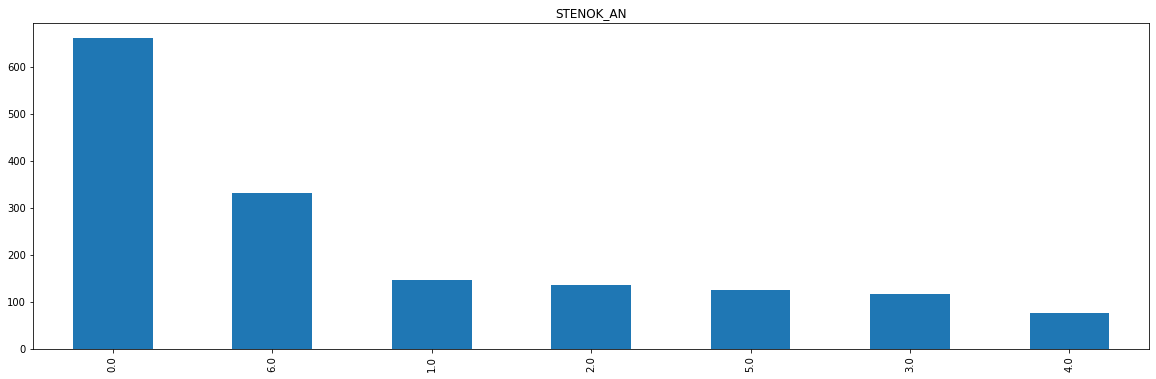

In [66]:
raw_xls[categorical_features[2]].value_counts().plot(kind='bar', subplots=True, figsize=(20,6))

TODO: выделить все бинарные

найти те, где одно из значений чаще 90% (+/-) - кандидат "на выкинуть"

для остальных построить barplot по всем и по классам (7 и 2)

Отдельно выделить не бинарные + графики

Поиск столбцов где одно из значение повторяется выше 90%

In [48]:

num_rows = len(raw_xls.index)
low_information_cols = [] #

for col in raw_xls.columns:
    cnts = raw_xls[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.90:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

SIM_GIPERT: 96.46182%
0.0    1554
1.0      53
NaN       4
Name: SIM_GIPERT, dtype: int64

nr_11: 96.95841%
0.0    1562
1.0      40
NaN       9
Name: nr_11, dtype: int64

nr_01: 99.25512%
0.0    1599
NaN       9
1.0       3
Name: nr_01, dtype: int64

nr_02: 98.32402%
0.0    1584
1.0      18
NaN       9
Name: nr_02, dtype: int64

nr_03: 97.39292%
0.0    1569
1.0      33
NaN       9
Name: nr_03, dtype: int64

nr_04: 97.76536%
0.0    1575
1.0      27
NaN       9
Name: nr_04, dtype: int64

nr_07: 99.37927%
0.0    1601
NaN       9
1.0       1
Name: nr_07, dtype: int64

nr_08: 99.19305%
0.0    1598
NaN       9
1.0       4
Name: nr_08, dtype: int64

np_01: 99.44134%
0.0    1602
NaN       7
1.0       2
Name: np_01, dtype: int64

np_04: 99.37927%
0.0    1601
NaN       7
1.0       3
Name: np_04, dtype: int64

np_05: 98.88268%
0.0    1593
1.0      11
NaN       7
Name: np_05, dtype: int64

np_07: 99.50341%
0.0    1603
NaN       7
1.0       1
Name: np_07, dtype: int64

np_08: 99.25512%
0.0    1599
N

In [49]:
knn_data_clear = knn_data.copy()
avg_data_clear = avg_data.copy()
moda_data_clear = moda_data.copy()
knn_data_clear = knn_data.drop(low_information_cols, axis=1)
avg_data_clear = avg_data.drop(low_information_cols, axis=1)
moda_data_clear = moda_data.drop(low_information_cols, axis=1)

TODO: Можно ли кактегории с порядком перевести в числовые?!

In [50]:
moda_data_clear

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,...,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n,FIBR_PREDS,ZSN,LET_IS,DEATH
0,49.0,0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,0
1,65.0,0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,58.0,1,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,43.0,1,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,49.0,1,0.0,4.0,2.0,1.0,2.0,3.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,62.0,1,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,1
1696,70.0,0,0.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1
1697,70.0,0,0.0,6.0,2.0,1.0,2.0,7.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1698,79.0,0,2.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1


Убираем поля с определением исхода болезни, оставляем только жив (0) или нет (1)

In [51]:
knn_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
avg_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
moda_data.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
knn_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
avg_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)
moda_data_clear.drop(columns=['FIBR_PREDS','ZSN','LET_IS'],inplace=True)

In [44]:
def Normalization (dataframe):
    for column in dataframe.columns:
        dataframe[column] =(dataframe[column] - dataframe[column].min()) / (dataframe[column].max() - dataframe[column].min()) 
    return dataframe

In [52]:
knn_data = Normalization(knn_data)
avg_data = Normalization(avg_data)
moda_data = Normalization(moda_data)
knn_data_clear = Normalization(knn_data_clear)
avg_data_clear = Normalization(avg_data_clear)
moda_data_clear = Normalization(moda_data_clear)

In [53]:
moda_data_clear

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n,DEATH
0,0.348485,0.0,0.000000,0.000000,0.00,1.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.590909,0.0,0.000000,0.166667,0.25,0.5,0.666667,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,0.484848,1.0,0.000000,0.000000,0.00,1.0,0.666667,0.2,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.257576,1.0,0.666667,0.333333,0.25,1.0,0.000000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.348485,1.0,0.000000,0.666667,0.25,0.5,0.666667,0.3,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,0.545455,1.0,0.000000,0.000000,0.00,0.0,0.000000,0.7,0.0,0.0,...,0.50,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1696,0.666667,0.0,0.000000,0.333333,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1697,0.666667,0.0,0.000000,1.000000,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1698,0.803030,0.0,0.333333,0.333333,0.25,0.5,0.666667,0.7,0.0,0.0,...,0.25,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [56]:
knn_data.to_csv('../data/knn_data.csv',index = False)
avg_data.to_csv('../data/avg_data.csv',index = False)
moda_data.to_csv('../data/moda_data.csv',index = False)
knn_data_clear.to_csv('../data/knn_data_clear.csv',index = False)
avg_data_clear.to_csv('../data/avg_data_clear.csv',index = False)
moda_data_clear.to_csv('../data/moda_data_clear.csv',index = False)

TODO: Результаты:

* какие выкинуть (сохранить полную и без "пустых" (несколько вариантов ?))
* варианты как заполнить с учетом распределения (несколь ко БД)

3 базы с заполнение пустых значений по следующим методам:
* средняя
* мода
* knn

из этих трех базы сделаны еще 3 базы без столбцов в которых значения повторяются чаще чем в 90% случаях

все 6 баз будут разделены на 3 дня и в итоге получается 18 баз, по 6 баз на каждый период

Глупая модель

Оценка?

* стратифицированная
* 5-10 случайных разбивок и показать статистику результатов
* Loss - кросс-энтропия, показатели - F1 + accuracy + confusion matrix


TODO: 

* линейная модель (2 классов) - посмотреть коэффициенты (важность) для масштабированных данных [0, 1]
* random forest - важность переменных
* НС (colab + TF + softmax (2 и 7) + sigmoid/ReLU) 

TODO доп: 

* PCA для числовыхю Глянуть объясн.дисперсию
* feature selection (2^n)

In [20]:
def Linear_model_function (X,y):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    feature_names = X.columns

    model_coefficients = regressor.coef_

    coefficients_df = pd.DataFrame(data = model_coefficients, 
                                  index = feature_names, 
                                  columns = ['Coefficient value'])
    print(coefficients_df)
    
    y_pred = regressor.predict(X_test)
    
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(results)
    
    fscore = f1_score(y_test,np.round(abs(y_pred)))
    acc = accuracy_score(y_test, np.round(abs(y_pred)))
 
    print(f'F-score: {fscore:.2f}')
    print(f'Accuracy_score: {acc:.2f}')


In [21]:
def SVM_model_function (X,y):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
    SVM = svm.LinearSVC()
    SVM.fit(X_train, y_train)

    y_pred = SVM.predict(X_test)
    
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(results)
    
    fscore = f1_score(y_test,np.round(abs(y_pred)))
    acc = accuracy_score(y_test, np.round(abs(y_pred)))
 
    print(f'F-score: {fscore:.2f}')
    print(f'Accuracy_score: {acc:.2f}')

In [22]:
def RF_model_function (X,y):  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 
    RF = RandomForestClassifier(n_estimators=1000, max_depth=60, random_state=0)
    RF.fit(X_train, y_train)

    y_pred = RF.predict(X_test)
    
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print(results)
    
    fscore = f1_score(y_test,np.round(abs(y_pred)))
    acc = accuracy_score(y_test, np.round(abs(y_pred)))
 
    print(f'F-score: {fscore:.2f}')
    print(f'Accuracy_score: {acc:.2f}')

In [52]:
normalized_df = moda_data_clear.copy()
for column in normalized_df.columns:
    normalized_df[column] =(normalized_df[column] - normalized_df[column].min()) / (normalized_df[column].max() - normalized_df[column].min()) 
    

In [53]:
y = normalized_df['DEATH']
X = normalized_df.drop(columns = ['DEATH'])

In [34]:
y = knn_data_clear['DEATH']
X = knn_data_clear.drop(columns = ['DEATH'])

In [35]:
X

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,endocr_01,...,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TRENT_S_n
0,49.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,65.0,0.0,0.0,1.0,2.0,1.0,2.0,4.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,58.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,43.0,1.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,49.0,1.0,0.0,4.0,2.0,1.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,62.0,1.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
1607,70.0,0.0,0.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1608,70.0,0.0,0.0,6.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1609,79.0,0.0,2.0,2.0,2.0,1.0,2.0,7.0,0.0,0.0,...,0.0,1.0,0.2,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [30]:
Linear_model_function(X,y)

               Coefficient value
AGE                     0.258703
SEX                     0.009513
INF_ANAM                0.015179
STENOK_AN               0.021299
FK_STENOK              -0.047875
IBS_POST                0.079114
GB                      0.086759
DLIT_AG                 0.001062
ZSN_A                   0.271411
endocr_01               0.064594
S_AD_ORIT              -0.322529
D_AD_ORIT              -0.363451
ant_im                  0.109923
lat_im                  0.121989
inf_im                  0.125493
post_im                -0.015028
ritm_ecg_p_01          -0.019874
ritm_ecg_p_02           0.156300
ritm_ecg_p_07           0.068741
n_r_ecg_p_03           -0.023993
GIPO_K                 -0.032763
K_BLOOD                 0.006302
GIPER_NA               -0.036129
NA_BLOOD               -0.005158
ALT_BLOOD              -0.110117
AST_BLOOD               0.009018
L_BLOOD                 0.141346
ROE                     0.067384
TIME_B_S               -0.081934
R_AB_1_n  

In [31]:
SVM_model_function (X,y)

      Actual  Predicted
29       0.0        0.0
266      1.0        0.0
393      0.0        0.0
437      0.0        0.0
246      0.0        0.0
...      ...        ...
1036     0.0        0.0
1634     1.0        0.0
525      0.0        0.0
434      0.0        0.0
1127     0.0        0.0

[323 rows x 2 columns]
F-score: 0.51
Accuracy_score: 0.88


In [38]:
RF_model_function (X,y)

      Actual  Predicted
29       0.0        0.0
266      1.0        0.0
393      0.0        0.0
437      0.0        0.0
246      0.0        0.0
...      ...        ...
1036     0.0        0.0
1634     1.0        0.0
525      0.0        0.0
434      0.0        0.0
1127     0.0        0.0

[323 rows x 2 columns]
F-score: 0.42
Accuracy_score: 0.88


* classification report
* добавить в colab
* сделать выгрузку в файлы
* пересмотреть архитектуру
* пересмотреть ошибку
* cv grid search

In [62]:
def Keras_model_function (X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 
    print(f"Количество строк в y_train по классам: {np.bincount(y_train)}")
    print(f"Количество строк в y_test по классам: {np.bincount(y_test)}")
    model = Sequential()
    model.add(Dense(48, input_shape=(48,), activation='relu'))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size = 2,validation_data=(X_test, y_test))
    _, accuracy = model.evaluate(X_train, y_train)
    print('Accuracy train: %.2f' % (accuracy*100))
    
    y_pred = model.predict(X_test)
    #y_pred = y_pred.reshape(323,)
    #results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    #print(results)
    
    fscore = f1_score(y_test,np.round(y_pred))
    acc = accuracy_score(y_test, np.round(y_pred))
    matrix = confusion_matrix(y_test, np.round(y_pred))
    
    print(f'F-score: {fscore:.2f}')
    print(f'Accuracy_score: {acc:.2f}')
    
    ax = sns.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [64]:
y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1695    1.0
1696    1.0
1697    1.0
1698    1.0
1699    1.0
Name: DEATH, Length: 1611, dtype: float64

Количество строк в y_train по классам: [1219  230]
Количество строк в y_test по классам: [136  26]
Epoch 1/30
97/97 [==============================] - 1s 3ms/step - loss: 0.8153 - accuracy: 0.7840 - val_loss: 0.3322 - val_accuracy: 0.8642
Epoch 2/30
97/97 [==============================] - 0s 2ms/step - loss: 0.4003 - accuracy: 0.8502 - val_loss: 0.3229 - val_accuracy: 0.8704
Epoch 3/30
97/97 [==============================] - 0s 2ms/step - loss: 0.3801 - accuracy: 0.8544 - val_loss: 0.2687 - val_accuracy: 0.8889
Epoch 4/30
97/97 [==============================] - 0s 2ms/step - loss: 0.3812 - accuracy: 0.8537 - val_loss: 0.3359 - val_accuracy: 0.9136
Epoch 5/30
97/97 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8502 - val_loss: 0.2842 - val_accuracy: 0.8889
Epoch 6/30
97/97 [==============================] - 0s 2ms/step - loss: 0.3597 - accuracy: 0.8558 - val_loss: 0.2694 - val_accuracy: 0.8827
Epoch 7/30
97/97 [==============================] - 0s 2ms/st

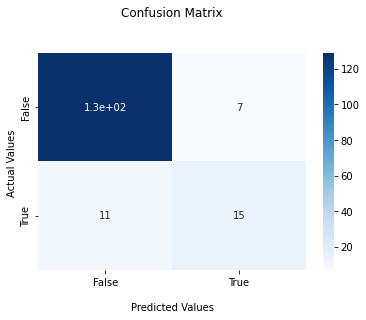

In [50]:
Keras_model_function (X,y)

Количество строк в y_train по классам: [1082  206]
Количество строк в y_test по классам: [273  50]
Epoch 1/10
644/644 [==============================] - 2s 2ms/step - loss: 0.3992 - accuracy: 0.8370 - val_loss: 0.3485 - val_accuracy: 0.8452
Epoch 2/10
644/644 [==============================] - 1s 1ms/step - loss: 0.3390 - accuracy: 0.8470 - val_loss: 0.3341 - val_accuracy: 0.8452
Epoch 3/10
644/644 [==============================] - 1s 1ms/step - loss: 0.3198 - accuracy: 0.8688 - val_loss: 0.3204 - val_accuracy: 0.8669
Epoch 4/10
644/644 [==============================] - 1s 1ms/step - loss: 0.3155 - accuracy: 0.8719 - val_loss: 0.3018 - val_accuracy: 0.8731
Epoch 5/10
644/644 [==============================] - 1s 1ms/step - loss: 0.2992 - accuracy: 0.8711 - val_loss: 0.3020 - val_accuracy: 0.8638
Epoch 6/10
644/644 [==============================] - 1s 1ms/step - loss: 0.2839 - accuracy: 0.8828 - val_loss: 0.3312 - val_accuracy: 0.8731
Epoch 7/10
644/644 [=============================

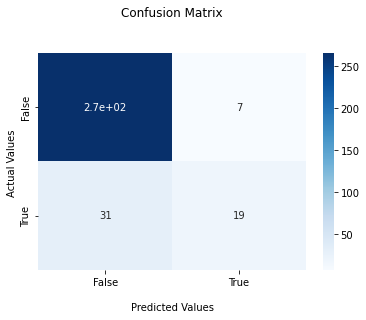

In [63]:
Keras_model_function (X,y)